['1182626900', '2917038141', '2997136966', '1590501091', '2917038151', '311727746', '312711008', 'cluster_gneJ684_gneJ691', 'cluster_gneJ689_gneJ690', 'cluster_365935389_4924343194']
['1182626900', 'cluster_499322353_gneJ427', 'cluster_371086199_gneJ299', '1225263707', 'cluster_289029338_gneJ105', '1225263519', '3991653884', '2916306951', '380456459', 'cluster_2894959538_gneJ29', '2137104268', '1760025970', '1416081318', 'cluster_cluster_2907020052_gneJ382_gneJ378', 'cluster_1184280674_4523347826_4523347827', 'cluster_gneJ689_gneJ690', 'gneJ432', 'cluster_gneJ462_gneJ463', 'cluster_cluster_gneJ499_gneJ500_gneJ580_gneJ583_gneJ585_gneJ586', 'cluster_gneJ508_gneJ509', 'cluster_gneJ551_gneJ552', 'cluster_gneJ568_gneJ569', '830321479', 'cluster_3192392585_3192392586', '1355696703', 'cluster_cluster_cluster_276755916_gneJ285_gneJ293_gneJ158', '3936317575', '289028061', '60054572', 'gneJ71', '2907026062', 'cluster_gneJ608_gneJ610_gneJ625_gneJ633'] ['2917038141', 'gneJ426', '3168945341', '1344

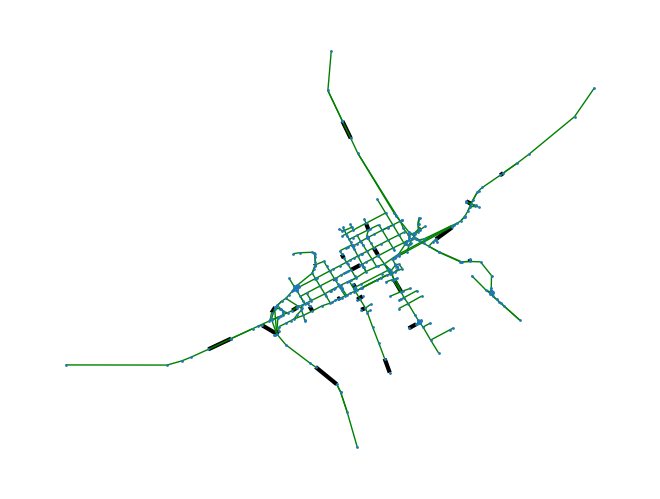

In [1]:
import sumolib
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

import torch
import torch_geometric
import torch_geometric.data as Data
import torch_geometric.utils as pyg_utils

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import json
import sys
import import_ipynb
%run ./Data_handling.ipynb
%run ./Data_visualization.ipynb
%run ./Model.ipynb
%run ./Analysis.ipynb

## Data handling

In [2]:
G1 = read_sumo_net1('../Data/s_gyor.net.xml') # type: ignore
#G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"0.00")
#pyg_data = nx_to_pyg(G2)

In [6]:
G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"10800.00")
with open('../Data/edges_to_hide.json', 'r') as file:
    edges_to_hide = json.load(file)
data = torch.load('../Data/data.pth')
print(data[0].x)

tensor([[  861.5900,  1045.6100],
        [  866.2500,  1037.0000],
        [ 1078.6300,  1419.6200],
        [ 1085.9301,  1330.5000],
        [ 2225.4299,   579.4400],
        [ 2305.6299,   430.3400],
        [ 2194.5000,   624.5000],
        [ 2191.9199,   629.0800],
        [ 1646.4600,  1608.1300],
        [ 1707.7200,  1642.4600],
        [ 1927.3300,  1304.2000],
        [ 1932.1200,  1287.6400],
        [ 1899.1100,  1364.8000],
        [ 1528.6600,   998.5800],
        [ 1840.9900,  1173.3600],
        [ 2833.1399,  1326.5400],
        [ 2949.6699,  1168.7200],
        [ 1042.9800,   882.4800],
        [ 1186.6801,   959.4500],
        [ 1002.2500,   859.3500],
        [ 2173.8401,   658.5400],
        [ 2179.6001,   651.1300],
        [ 2171.0701,   663.1700],
        [ 2140.3301,   717.1600],
        [ 2617.9900,  1328.0800],
        [ 2629.6299,  1327.2900],
        [ 2719.4700,  1330.6300],
        [ 1616.5500,   796.9300],
        [ 1571.2700,   777.1900],
        [  703

## Initialization of the model

In [16]:
G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"10800.00")
with open('../Data/edges_to_hide.json', 'r') as file:
    edges_to_hide = json.load(file)
data = torch.load('../Data/data.pth')

prepared_training_data, prepared_test_data, summa = data_preparation(data, edges_to_hide,True)
print(summa)


# Define the model
edge_dim = 1  # Number of edge features
hidden_dim1 = 32
hidden_dim2 = 128
hidden_dim3 = 64
hidden_dim4 = 32
hidden_dim5 = 32
hidden_dim6 = 32
hidden_dim7 = 32
hidden_dim8 = 32

model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

training_the_model(model, optimizer, criterion, 100, prepared_test_data, prepared_training_data, edges_to_hide, 20)

#with open('total_losses.json', 'w') as file:
#    json.dump(total_losses, file)
#with open('losses.json', 'w') as file:
#    json.dump(losses, file)

tensor(0.0980)
Epoch 1, Loss: 0.12533944845199585
Epoch 21, Loss: 0.04928743466734886
Epoch 41, Loss: 0.06409019231796265
Epoch 61, Loss: 0.0631089136004448
Epoch 81, Loss: 0.05617464706301689


([0.12533944845199585,
  0.11057290434837341,
  0.109841488301754,
  0.09958244115114212,
  0.08963491022586823,
  0.07211223244667053,
  0.05550716072320938,
  0.07728870213031769,
  0.07519295811653137,
  0.0683957040309906,
  0.06384248286485672,
  0.04882846027612686,
  0.05803936347365379,
  0.0651857927441597,
  0.0632927194237709,
  0.06595849245786667,
  0.048037339001894,
  0.05432923883199692,
  0.057650741189718246,
  0.06718021631240845,
  0.04928743466734886,
  0.06446529179811478,
  0.055730804800987244,
  0.05059671401977539,
  0.05449290573596954,
  0.05089915171265602,
  0.0644596517086029,
  0.03848138079047203,
  0.06984901428222656,
  0.054847799241542816,
  0.06349793076515198,
  0.0613618828356266,
  0.0621802918612957,
  0.05868550390005112,
  0.06034485995769501,
  0.050741612911224365,
  0.06853710860013962,
  0.05000609531998634,
  0.04922663792967796,
  0.06219923868775368,
  0.06409019231796265,
  0.061307087540626526,
  0.05676131322979927,
  0.061637949198

In [65]:
torch.save(model.state_dict(), 'gnn_model_ces.pth')
#cep : change every step
layers = [model.conv1, model.conv2, model.conv3, model.conv4, model.conv5, model.conv6, model.conv7, model.conv8]
edge_dims = []
for layer in layers:
    edge_dims.append(layer.in_channels)
edge_dims.append(model.linear.in_features)
with open('dimensions.json','w') as file:
    json.dump(edge_dims, file)


## Loading the model
Once we trained it nd saved it, this is how we can load it

In [66]:
with open('edges_to_hide.json', 'r') as file:
    edges_to_hide = json.load(file)
data = torch.load('data.pth')

prepared_training_data, prepared_test_data, summa = data_preparation(data, edges_to_hide)

with open('dimensions.json', 'r') as file:
    edge_dims = json.load(file)

model2 = GNN(edge_dims[0], edge_dims[1], edge_dims[2], edge_dims[3], edge_dims[4], edge_dims[5], edge_dims[6], edge_dims[7], edge_dims[8])
model2.load_state_dict(torch.load('gnn_model_ces.pth'))
output = model2(prepared_training_data[3].edge_attr, prepared_training_data[3].edge_index)



<All keys matched successfully>

## Data visualization